In [1]:
import glob
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

import rocks
rocks.set_log_level("error")
import time as t


from astropy.time import Time
import requests
import io

import astropy.units as u
from astropy.coordinates import SkyCoord
from astropy.coordinates import angular_separation

from scipy.signal import argrelextrema


from fink_utils.sso import spins as finkus
import ssptools

# Get ZTF fit

In [2]:
# Local Configuration
bft_file = '/data/ssodnet/ssoBFT-latest.parquet'
data_fink = '/data/fink/tutorials/sso/spins/'
data_fink = './'

# To choose the definition of sets
# gold_silver_choice = 'julien'
gold_silver_choice = 'benoit'

In [3]:
# ZTF filters 1: g, 2: r
filters = {'1': 'g', '2': 'r'}

S_color = {'g': -0.3928, 'r':0.2913}
sun_color = {'g': -0.3044, 'r':0.1903}

color_C = -(sun_color['g']-sun_color['r'])
color_S = -(S_color['g']-S_color['r'])


In [36]:
data = pd.read_parquet(f'{data_fink}data/sso_bft_50_inf_allsolutions.parquet')

In [38]:
data['HG1G2hyb_dSpin'] = np.sqrt( (data['HG1G2hyb_dRA0']*np.cos(np.radians(data['HG1G2hyb_DEC0'])))**2 + data['HG1G2hyb_dDEC0']**2 )


# Remove solutions above 90 deg of latitude
cond = data.HG1G2hyb_DEC0 > 90
data.loc[cond,'HG1G2hyb_DEC0'] = 90
cond = data.HG1G2hyb_DEC0 < -90
data.loc[cond,'HG1G2hyb_DEC0'] = -90

# Spin coordinates: long/lat
# Define angle for astropy
ra = data.HG1G2hyb_RA0*u.degree
dec = data.HG1G2hyb_DEC0*u.degree

# Convert to EC and store in the pandas DataFrame
coords = SkyCoord(ra=ra, dec=dec, distance=200*u.parsec, frame='hcrs')
data['lon'] = coords.heliocentricmeanecliptic.lon.value
data['lat'] = coords.heliocentricmeanecliptic.lat.value



In [5]:
bft = pd.read_parquet(bft_file)

In [39]:
cols = ['sso_number', 'sso_name', 'sso_class',
        'orbital_elements.semi_major_axis.value',
        'orbital_elements.eccentricity.value',
        'orbital_elements.inclination.value',
        'orbital_elements.node_longitude.value',
        'orbital_elements.perihelion_argument.value',
        'orbital_elements.mean_anomaly.value',
        'orbital_elements.mean_motion.value',
        'family.family_number', 'family.family_name',
        'tisserand_parameters.Jupiter.value',
        'albedo.value',
        'absolute_magnitude.value', 
        'diameter.value', 
        'taxonomy.class', 'taxonomy.complex', 'taxonomy.waverange', 'taxonomy.scheme', 'taxonomy.technique',
        'colors.g-r.color.value', 'colors.g-r.color.error.min', 'colors.g-r.color.error.max',
        'colors.g-r.facility', 'colors.g-r.observer', 'colors.g-r.epoch',
        'colors.g-r.delta_time', 'colors.g-r.id_filter_1',
        'colors.g-r.id_filter_2', 'colors.g-r.phot_sys', 'colors.g-r.technique',
        'spins.1.obliquity', 'spins.1.RA0.value', 'spins.1.DEC0.value',
        'spins.1.long.value', 'spins.1.lat.value', 'spins.1.technique',
        'spins.2.obliquity', 'spins.2.RA0.value', 'spins.2.DEC0.value',
        'spins.2.long.value', 'spins.2.lat.value', 'spins.2.technique']        

In [40]:
data = data.merge( bft[cols], left_on='name', right_on='sso_name', how='left' )

In [41]:
data

,ssnamenr,number,name,minphase,maxphase,n_days,n_obs,HG_H,HG_dH,HG_G,...,spins.1.DEC0.value,spins.1.long.value,spins.1.lat.value,spins.1.technique,spins.2.obliquity,spins.2.RA0.value,spins.2.DEC0.value,spins.2.long.value,spins.2.lat.value,spins.2.technique
0,3378,3378,Susanvictoria,7.209902,27.973639,694.757685,163,13.835591,0.073765,0.186857,...,NaN,NaN,NaN,LC,NaN,NaN,NaN,NaN,NaN,None
1,66214,66214,1999 CO36,2.763971,24.397613,972.951458,73,15.128266,0.062540,0.027824,...,NaN,NaN,NaN,None,NaN,NaN,NaN,NaN,NaN,None
2,30141,30141,Nelvenzon,3.434811,23.955449,621.800359,53,16.165762,0.136274,0.613963,...,NaN,NaN,NaN,LC,NaN,NaN,NaN,NaN,NaN,None
3,161891,161891,2007 DW10,1.758005,21.985170,632.723530,61,15.447201,0.046601,0.117947,...,NaN,NaN,NaN,None,NaN,NaN,NaN,NaN,NaN,None
4,85970,85970,Fundacaoterra,0.822790,22.376936,998.833889,54,15.927574,0.101270,0.443576,...,NaN,NaN,NaN,None,NaN,NaN,NaN,NaN,NaN,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
104160,64758,64758,2001 XL163,1.497470,29.740566,608.827500,79,15.778768,0.072580,0.114509,...,NaN,NaN,NaN,None,NaN,NaN,NaN,NaN,NaN,None
104161,76784,76784,2000 KR71,1.830102,25.589995,990.106308,82,15.468660,0.065853,0.093753,...,NaN,NaN,NaN,None,NaN,NaN,NaN,NaN,NaN,None
104162,181960,181960,1999 UM24,1.875814,18.193628,973.847419,107,14.037718,0.076177,0.000482,...,NaN,NaN,NaN,None,NaN,NaN,NaN,NaN,NaN,None
104163,366616,366616,2003 NP4,26.050772,37.302272,242.663241,153,16.717611,0.113371,0.149370,...,NaN,NaN,NaN,None,NaN,NaN,NaN,NaN,NaN,None


In [42]:
thres = 1e-3

maskG1G2 = (data.HG1G2_G1>thres)  & (data.HG1G2_G2>thres) & (1-data.HG1G2_G1-data.HG1G2_G2>thres)
maskG1G2sp = (data.HG1G2sp_G1>thres)  & (data.HG1G2sp_G2>thres) & (1-data.HG1G2sp_G1-data.HG1G2sp_G2>thres)
maskG1G2hyb_g = (data.HG1G2hyb_G1_g>thres)  & (data.HG1G2hyb_G2_g>thres) & (1-data.HG1G2hyb_G1_g-data.HG1G2hyb_G2_g>thres)
maskG1G2hyb_r = (data.HG1G2hyb_G1_r>thres)  & (data.HG1G2hyb_G2_r>thres) & (1-data.HG1G2hyb_G1_r-data.HG1G2hyb_G2_r>thres)
maskG1G2hyb = maskG1G2hyb_g * maskG1G2hyb_r

maskPhase = data.minphase<2.5
mask = maskG1G2 * maskG1G2sp * maskG1G2hyb * maskPhase

maskFINK = maskG1G2hyb * maskPhase

len(data), len(data[mask]), len(data[maskG1G2]), len(data[maskG1G2sp]), len(data[maskG1G2hyb_g]), len(data[maskG1G2hyb_r]), len(data[maskG1G2hyb])

(104165, 24936, 57063, 66319, 53745, 57538, 42235)

# Check results for individual SSOs

In [43]:
data['spins.1.technique'].value_counts()

LC        15872
LCI        2654
LC+TPM      568
TE           90
ADAM         42
LC-TPM       40
LC+Occ       16
Radar        16
SPACE         5
A-M           5
LC+IM         4
SAGE          4
Bin-IM        1
TE-Occ        1
Name: spins.1.technique, dtype: int64

Text(0.5, 0, 'Uncertainty on spin coordinates (deg.)')

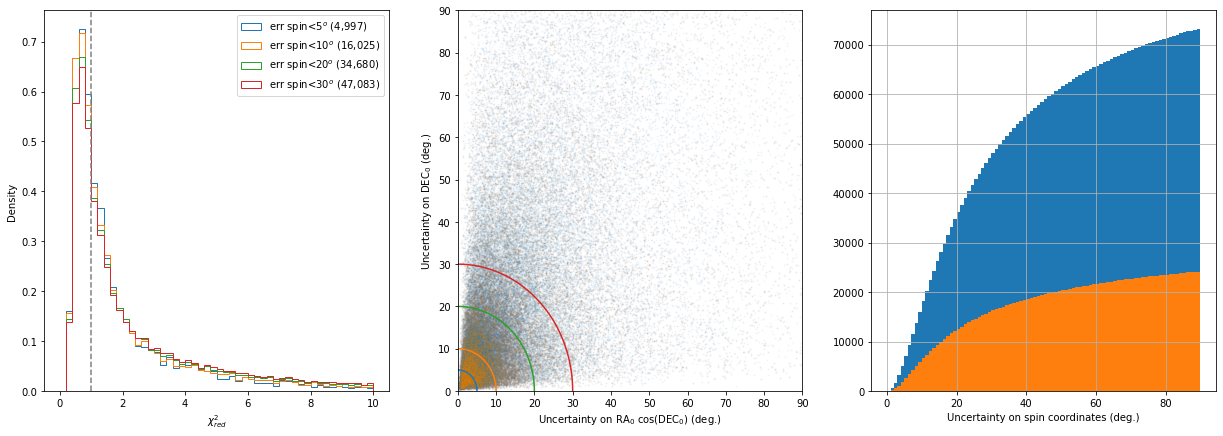

In [57]:
fig, ax = plt.subplots(1, 3, figsize=(21,7))


for err in [5,10,20,30]:
    cond = (data.HG1G2hyb_dSpin<=err)
    ax[0].hist(data.loc[cond,'HG1G2hyb_chi2red'], bins=50, histtype='step', density=True, range=[0,10],
               label=f'err spin<{err:d}$^o$ ({len(data[cond]):,d})')

    theta = np.linspace(0, np.pi/2, num=90 )
    ax[1].plot( err*np.cos(theta), err*np.sin(theta) )
    
ax[0].axvline(1, ls='--', color='grey')
ax[0].set_xlabel(r'$\chi^2_{red}$')
ax[0].set_ylabel('Density')
ax[0].legend()



ax[1].scatter( data.HG1G2hyb_dRA0*np.cos(np.radians(data['HG1G2hyb_DEC0'])), data.HG1G2hyb_dDEC0, s=1, alpha=0.05 )
ax[1].scatter( data.loc[maskFINK,'HG1G2hyb_dRA0']*np.cos(np.radians(data.loc[maskFINK,'HG1G2hyb_DEC0'])), data.loc[maskFINK,'HG1G2hyb_dDEC0'], s=1, alpha=0.05 )
ax[1].set_xlim(0,90)
ax[1].set_ylim(0,90)

ax[1].set_xlabel('Uncertainty on RA$_0$ cos(DEC$_0$) (deg.)')
ax[1].set_ylabel('Uncertainty on DEC$_0$ (deg.)')

ax[2].hist( data.HG1G2hyb_dSpin, cumulative=True, density=False, range=[0,90], bins=90 )
ax[2].hist( data.loc[maskFINK,'HG1G2hyb_dSpin'], cumulative=True, density=False, range=[0,90], bins=90 )

ax[2].grid()
ax[2].set_xlabel('Uncertainty on spin coordinates (deg.)')

# fig.savefig(f'{data_fink}plots/uncertainties_spin.png', facecolor='white', dpi=150)


Text(0, 0.5, 'DEC0 (deg)')

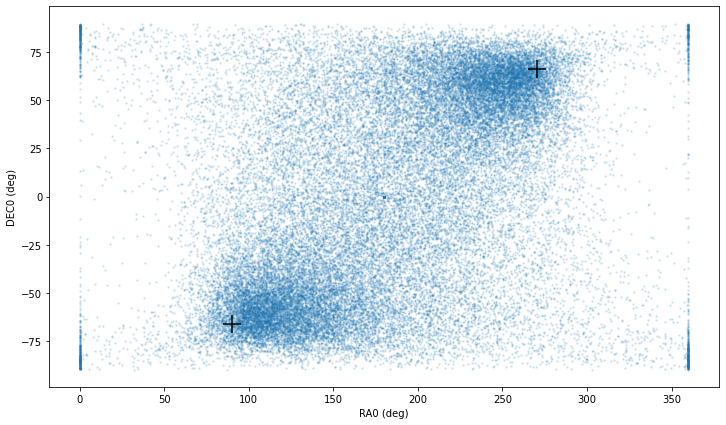

In [60]:
fig, ax = plt.subplots(figsize=(12, 7))

cond = (data.index %2 ==0 )
xax = 'HG1G2hyb_RA0'
yax = 'HG1G2hyb_DEC0'

ax.scatter( data.loc[cond,xax], 
            data.loc[cond,yax], 
          s=2, alpha=0.15)

coords = SkyCoord(lon=0.1*u.degree, lat=89.9*u.degree, distance=200*u.parsec, frame='heliocentricmeanecliptic')
ax.scatter( coords.hcrs.ra.value, coords.hcrs.dec.value, marker='+', s=300,color='black' )
coords = SkyCoord(lon=0.1*u.degree, lat=-89.9*u.degree, distance=200*u.parsec, frame='heliocentricmeanecliptic')
ax.scatter( coords.hcrs.ra.value, coords.hcrs.dec.value, marker='+', s=300,color='black' )


ax.set_xlabel('RA0 (deg)')
ax.set_ylabel('DEC0 (deg)')
# fig.savefig(f'{data_fink}plots/ra0_vs_dec0_with_flip.png', facecolor='white', dpi=150)



- There are a few weird solution at RA0=0 or RA0=360 
- We need to flip RA/DEC of half the solution

In [61]:
cond = (data.index %2 ==0 )
xax = 'HG1G2hyb_RA0'
yax = 'HG1G2hyb_DEC0'

data.loc[cond,xax] = (data.loc[cond,xax]-180) % 360
data.loc[cond,yax] = -data.loc[cond,yax]

Text(0, 0.5, 'DEC0 (deg)')

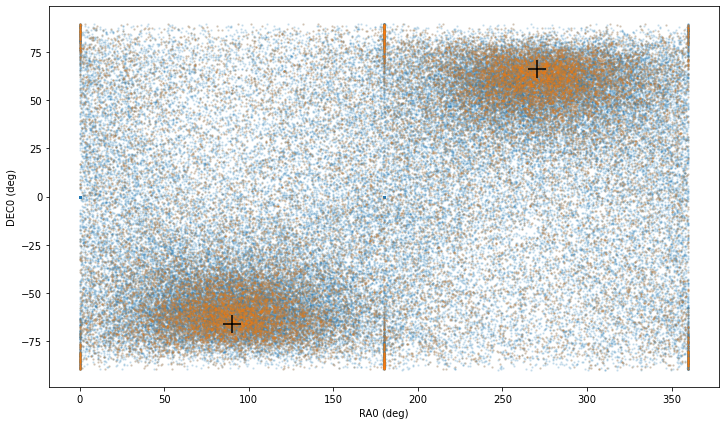

In [63]:
fig, ax = plt.subplots(figsize=(12, 7))

cond = data.ssnamenr==data.ssnamenr
xax = 'HG1G2hyb_RA0'
yax = 'HG1G2hyb_DEC0'

ax.scatter( data.loc[cond,xax], 
            data.loc[cond,yax], 
          s=2, alpha=0.15)

ax.scatter( data.loc[maskFINK,xax], 
            data.loc[maskFINK,yax], 
          s=2, alpha=0.15)

coords = SkyCoord(lon=0.1*u.degree, lat=89.9*u.degree, distance=200*u.parsec, frame='heliocentricmeanecliptic')
ax.scatter( coords.hcrs.ra.value, coords.hcrs.dec.value, marker='+', s=300,color='black' )
coords = SkyCoord(lon=0.1*u.degree, lat=-89.9*u.degree, distance=200*u.parsec, frame='heliocentricmeanecliptic')
ax.scatter( coords.hcrs.ra.value, coords.hcrs.dec.value, marker='+', s=300,color='black' )


ax.set_xlabel('RA0 (deg)')
ax.set_ylabel('DEC0 (deg)')
# fig.savefig(f'{data_fink}plots/ra0_vs_dec0_with_flip.png', facecolor='white', dpi=150)

